In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import gensim
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec
import spacy
import string

import re


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dropout
from keras.regularizers import l1, l2

from collections import Counter

# Import Dataset

In [3]:
# import dataset from google drive

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
df = pd.read_csv("/content/drive/My Drive/Course/Data Science/Project/Project 2 - Cyber Bulling Text Prediction/cyberbullying_tweets.csv")
df.head(3)

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [6]:
# check duplicated data

df.duplicated().sum()

36

In [7]:
df = df.drop_duplicates()

In [8]:
df['cyberbullying_type'].value_counts()

cyberbullying_type
religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: count, dtype: int64

The data is very well balance

In [9]:
# convert all the data type into string or object for preprocessing purpose

text = df['tweet_text'].astype(str)

# EDA

In [10]:
from collections import Counter # this library used to count every word inside the text

In [11]:
def Most_Words_used(data, num_of_words, type_of_bullying) :
    all_text = ''.join(data['tweet_text'][data['cyberbullying_type'] == type_of_bullying].values)

    # remove all symbols and word that unnecessary
    all_text = re.sub(r'http\S+', '', all_text)
    all_text = re.sub(r'@\S+', '', all_text)
    all_text = re.sub(r'#\S+', '', all_text)
    all_text = re.sub(r'\d+', '',all_text)
    all_text = re.sub(r'[^\w\s]', '',all_text)

    words = all_text.split() # split the word string into array

    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words] # remove all stopwords

    word_counts = Counter(words) # count the word within an array

    top_words = word_counts.most_common(num_of_words) # most common word

    return top_words

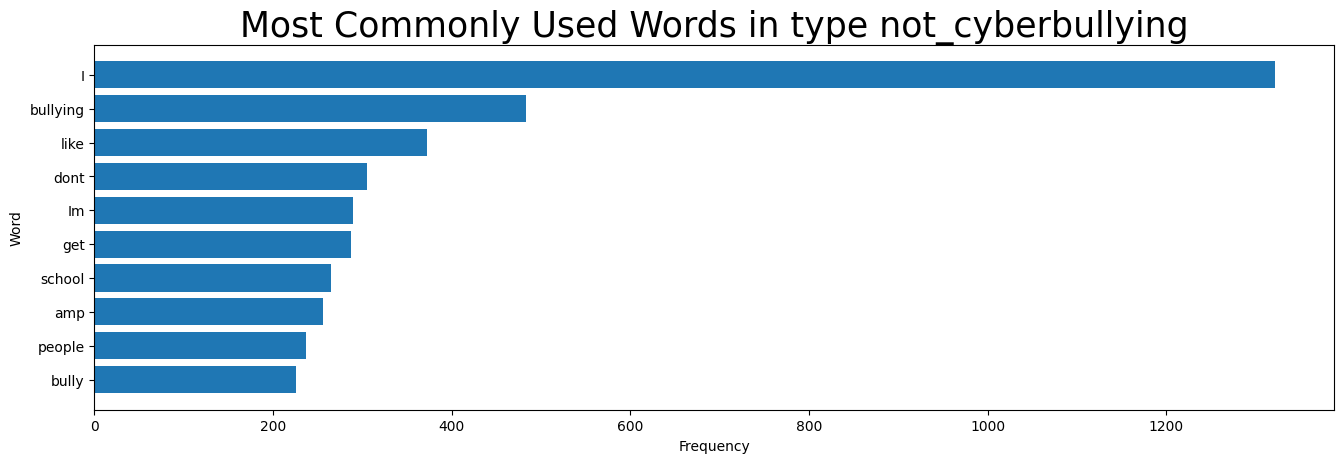

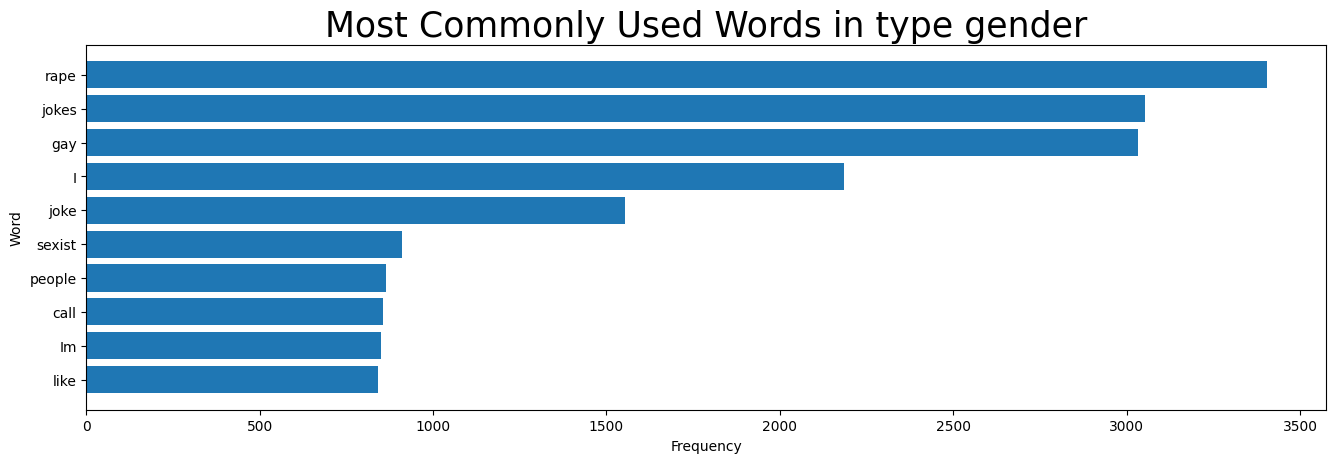

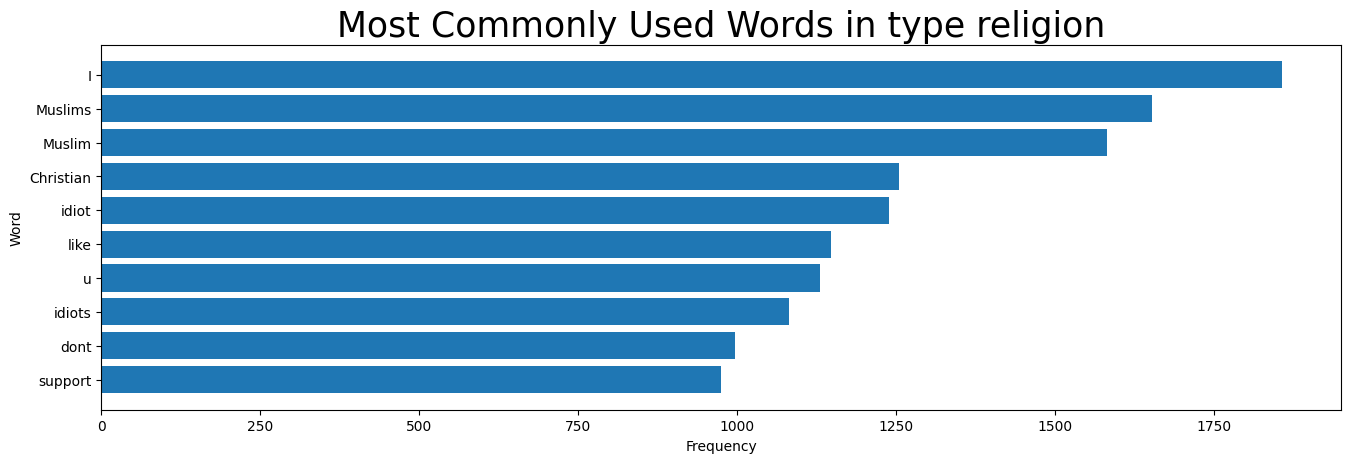

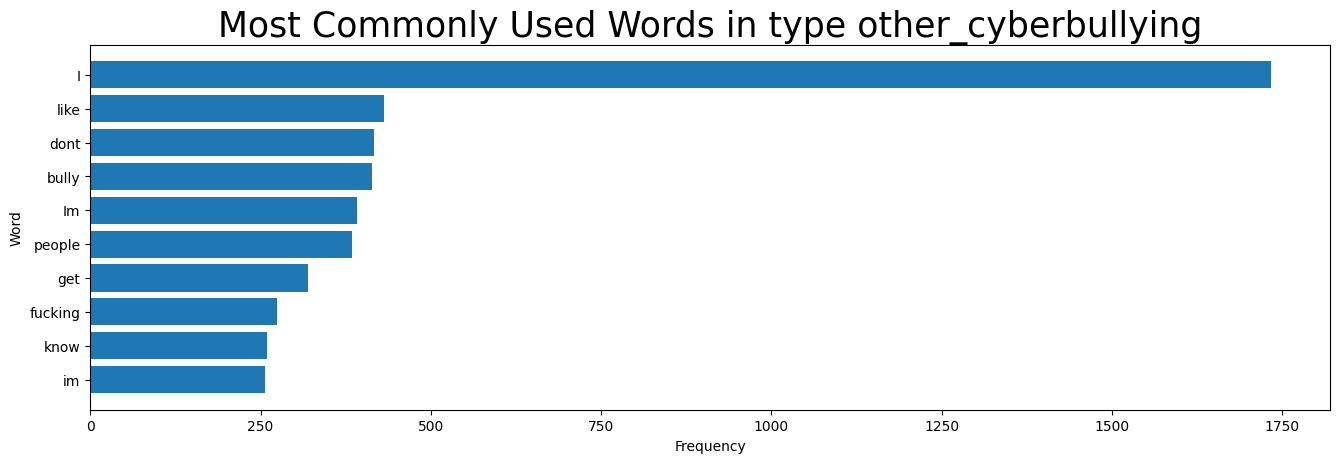

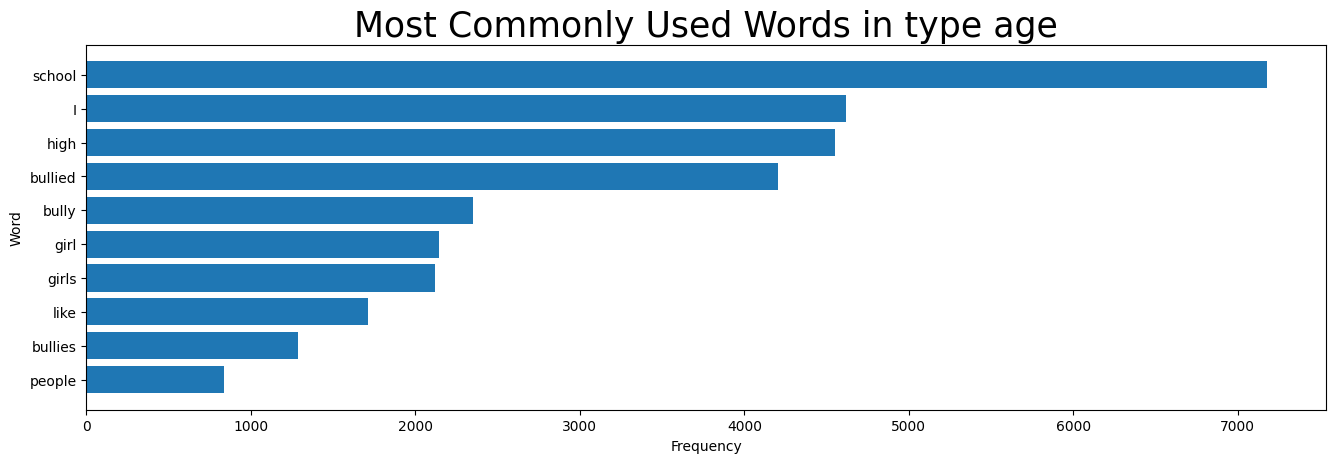

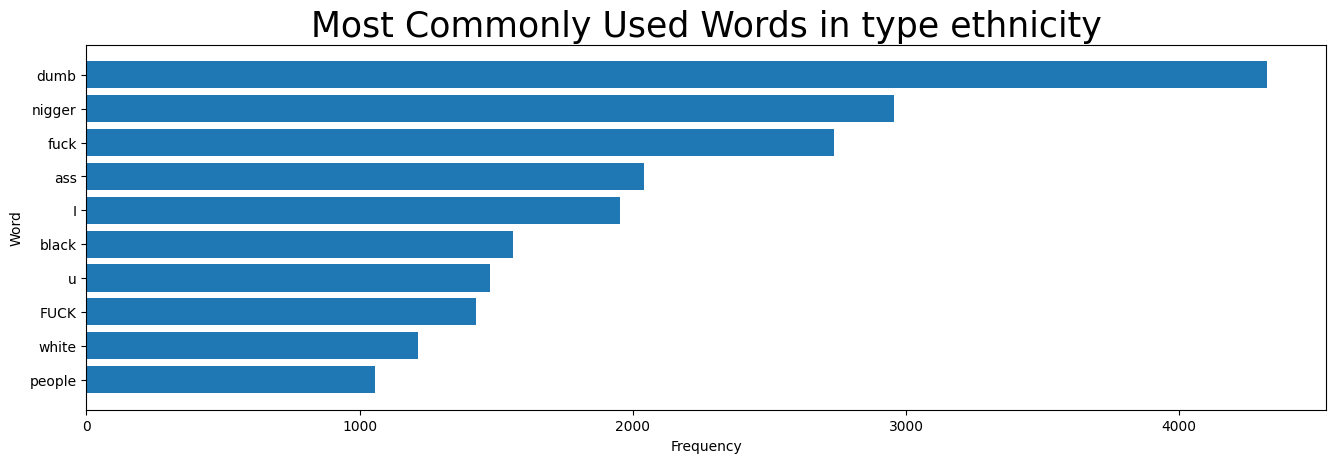

In [12]:
# show all the top_words that always appear for each cyberbullying text type

bullying_type = df['cyberbullying_type'].unique()
for _type in bullying_type:
  top_words = Most_Words_used(df, 10, _type) # top ten the most use word

  xaxis = [word[0] for word in top_words[::-1]]
  yaxis = [word[1] for word in top_words[::-1]]

  plt.figure(figsize=(16,5))
  plt.barh(xaxis , yaxis)
  plt.xlabel('Frequency')
  plt.ylabel('Word')
  plt.title(f'Most Commonly Used Words in type {_type}', fontsize=25)
  plt.subplots_adjust(bottom=0.15)
  plt.show()

After analyzing the most commonly used words for each type of cyberbullying and conducting some experiments, I have decided to exclude the "other_cyberbullying" type. This decision was made because the most frequently used words in this type are very similar to those in the "not_cyberbullying" type, resulting in overlap during the training of the data. We want to avoid situations where text that is not cyberbullying in real life is incorrectly detected as cyberbullying, as this could lead to an uncomfortable experience for users whose conversations are flagged, even though they are actually safe.

# Text Processing

## Cleansing

In [13]:
# cleansing the data with remove all symbols and word that unnecessary

def cleansing(text):
    text = text.apply(lambda x: re.sub(r'http\S+', '', x))
    text = text.apply(lambda x: re.sub(r'@\S+', '', x))
    text = text.apply(lambda x: re.sub(r'#\S+', '', x))
    text = text.apply(lambda x: re.sub(r'\d+', '', x))
    text = text.apply(lambda x: re.sub(r'[^\w\s]|[\d]', '', x))
    text = text.apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
    text = text.apply(lambda x: re.sub(r'@\w+|\#\w+', '', x))
    text = text.str.replace(r'\s+', ' ')
    return text.str.strip()

## Tokenization

In [14]:
# Split the string into array

def tokenization(text):
  text = text.apply(lambda x: word_tokenize(x))
  return text

## Removing Stopwords

In [15]:
# remove all the words that not recognize in english dictionary

def removing_stopwords(tokens):
  filter = []
  stop_words = set(stopwords.words('english'))
  for token in tokens:
    if token not in stop_words:
      filter.append(token)
  return filter

## Lemmatization

In [16]:
# convert all the words into their basic word and change them to lowercase

def lemmatize(data):
  lem_text = []
  lem = WordNetLemmatizer()
  for word in data:
    lem_text.append(lem.lemmatize(word, 'v'))
  return ' '.join(lem_text).lower()

## Removing Non Valuable Words For Categorization

In [17]:
def remove_NoV_word(text, word):
  NoV_word = word

  # Menghapus kata-kata tertentu dari teks
  for word in NoV_word:
      text = text.replace(word, ' ')

  return text.strip()


## Final Result

In [40]:
clear_text = text.copy()

In [41]:
clear_text = cleansing(clear_text)
clear_text = tokenization(clear_text)
clear_text = clear_text.apply(lambda x: removing_stopwords(x))
clear_text = clear_text.apply(lambda x: lemmatize(x))
clear_text = clear_text.apply(lambda x: remove_NoV_word(x, [' i ', ' u ', ' people ', ' im ', ' dont ',  ' like ']))

In [42]:
clear_text

0                                in word food crapilicious
1                                                why white
2                      classy whore or red velvet cupcakes
3        meh p thank head concern another angry dude tw...
4        this isis account pretend kurdish account isla...
                               ...                        
47687    black ppl arent expect anything depend anythin...
47688    turner withhold disappointment turner call cou...
47689    i swear god this dumb nigger bitch get bleach ...
47690    yea fuck rt if youre a nigger fucking unfollow...
47691    bro get ta chill rt dog fuck kp dumb nigger bi...
Name: tweet_text, Length: 47656, dtype: object

In [43]:
df_eda = df.copy()
df_eda['tweet_text'] = clear_text
df_eda = df_eda.drop(df_eda[df_eda['cyberbullying_type'] == 'other_cyberbullying'].index).reset_index()

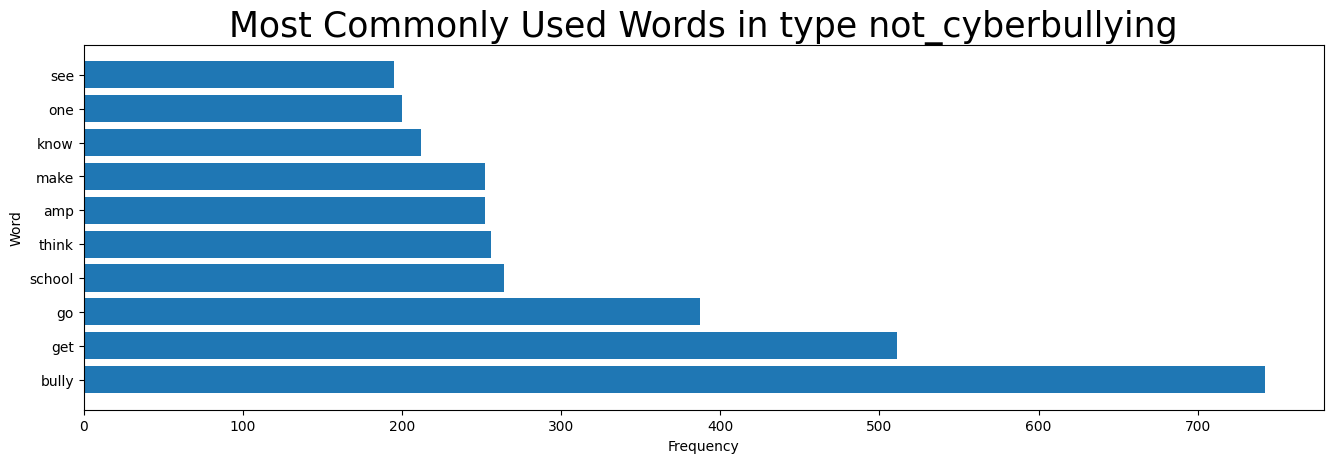

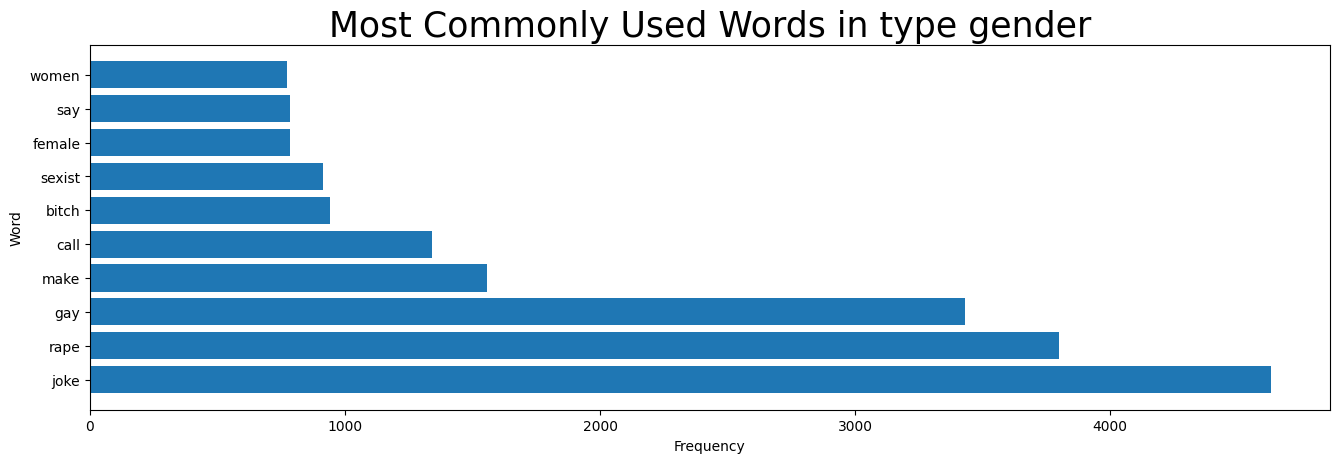

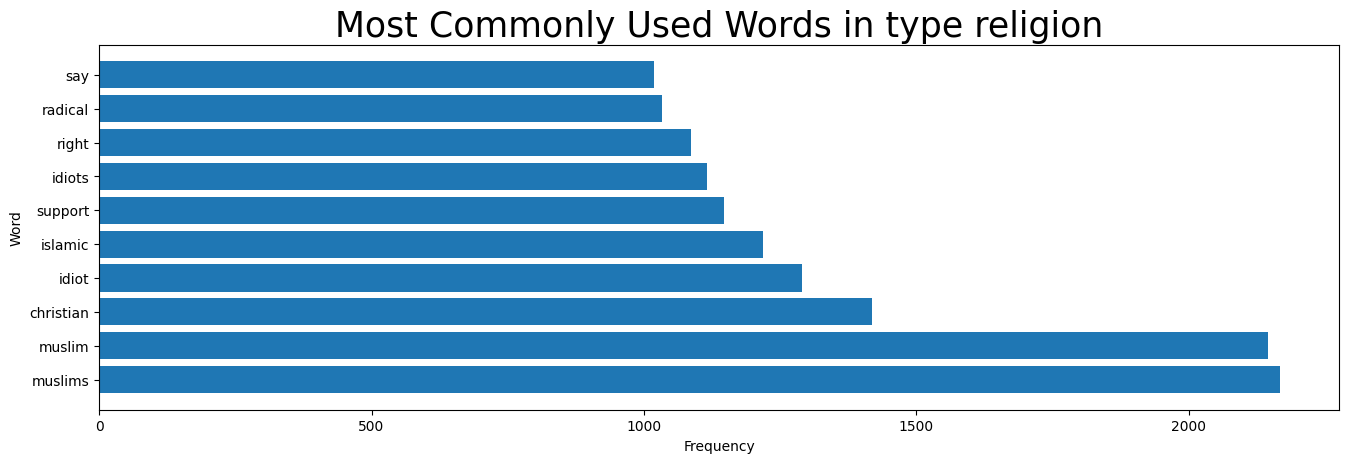

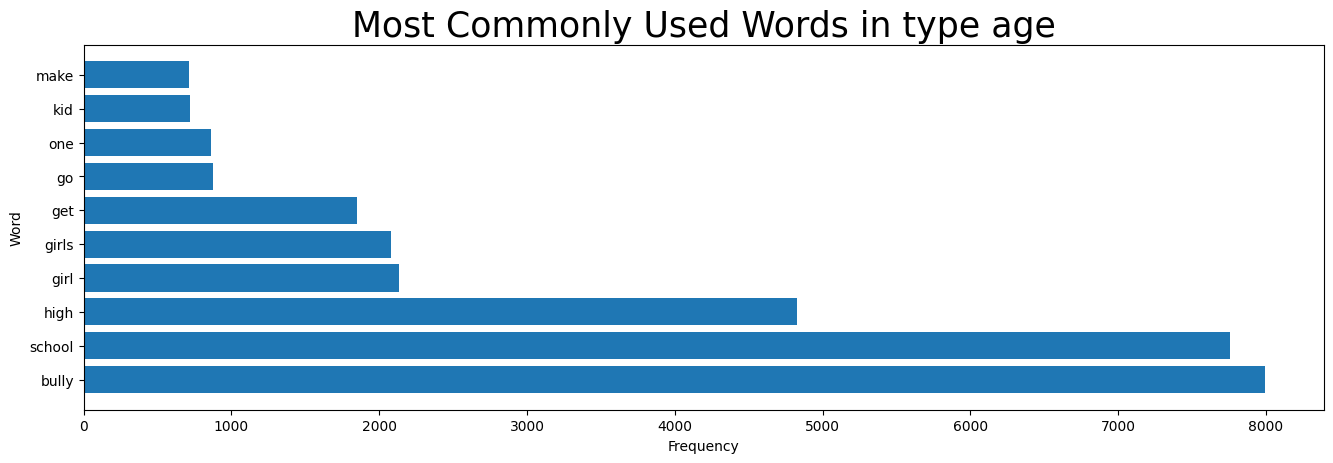

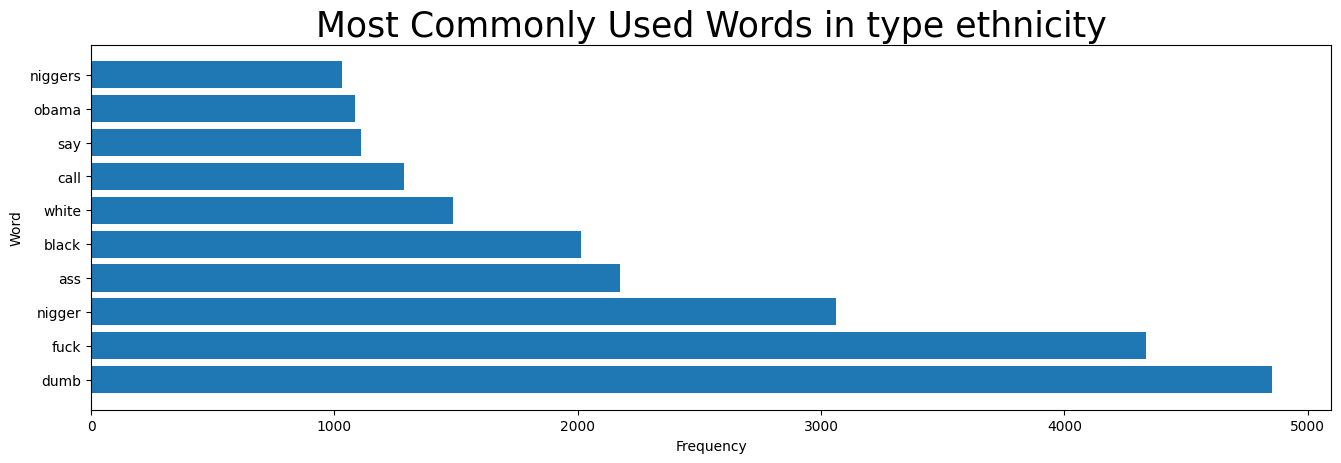

In [44]:
bullying_type = df_eda['cyberbullying_type'].unique()
for _type in bullying_type:
  top_words = Most_Words_used(df_eda, 10, _type)

  xaxis = [word[0] for word in top_words]
  yaxis = [word[1] for word in top_words]

  plt.figure(figsize=(16,5))
  plt.barh(xaxis , yaxis)
  plt.xlabel('Frequency')
  plt.ylabel('Word')
  plt.title(f'Most Commonly Used Words in type {_type}', fontsize=25)
  plt.subplots_adjust(bottom=0.15)
  plt.show()

# Data Preprocessing

In [45]:
df_tmp = df.copy()

In [46]:
df_tmp['tweet_text'] = clear_text

In [47]:
# remove "other_cyberbullying" type label (the reason is already mention in EDA section)

df_tmp = df_tmp.drop(df[df['cyberbullying_type'] == 'other_cyberbullying'].index).reset_index()

## Label Encoder

In [48]:
from sklearn.preprocessing import LabelEncoder

col = 'cyberbullying_type'

le = LabelEncoder()
le.fit(df_tmp[col])

df_tmp[col] = le.transform(df_tmp[col])

In [49]:
df_true = df.drop(df[df['cyberbullying_type'] == 'other_cyberbullying'].index).reset_index()['cyberbullying_type']
dictionary = dict(zip(df_true, df_tmp['cyberbullying_type']))

print("The result after the encoding:")
for nama_kolom, nilai_encoded in dictionary.items():
    print(f"{nama_kolom}: {nilai_encoded}")

The result after the encoding:
not_cyberbullying: 3
gender: 2
religion: 4
age: 0
ethnicity: 1


In [50]:
df_tmp

,index,tweet_text,cyberbullying_type
0,0,in word food crapilicious,3
1,1,why white,3
2,2,classy whore or red velvet cupcakes,3
3,3,meh p thank head concern another angry dude tw...,3
4,4,this isis account pretend kurdish account isla...,3
...,...,...,...
39828,47687,black ppl arent expect anything depend anythin...,1
39829,47688,turner withhold disappointment turner call cou...,1
39830,47689,i swear god this dumb nigger bitch get bleach ...,1
39831,47690,yea fuck rt if youre a nigger fucking unfollow...,1


# Split Data To Traning and Test Data

In [51]:
X = df_tmp['tweet_text']
y = df_tmp['cyberbullying_type']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [53]:
# convert single word into numeric representation using tf-idf equation
import pickle

vectorizer   = TfidfVectorizer()
vectorizer.fit(X_train)
pickle.dump(vectorizer.fit(X_train), open(f'vectorizer.pkl', 'wb'))
X_train_vecs = vectorizer.transform(X_train)
X_test_vecs  = vectorizer.transform(X_test)

In [54]:
X_train_vecs

<31866x33607 sparse matrix of type '<class 'numpy.float64'>'
	with 432773 stored elements in Compressed Sparse Row format>

In [55]:
# convert single word into their numeric representation (just like label encoder)
import pickle

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences  = tokenizer.texts_to_sequences(X_test)



In [56]:
# comment length with statistic

token_lengths = [len(sequence) for sequence in X_train_sequences]
mean_length   = np.mean(token_lengths)
median_length = np.median(token_lengths)
max_length    = int(mean_length + 2 * np.std(token_lengths))

print(f"Mean Token Length   : {mean_length}")
print(f"Median Token Length : {median_length}")
print(f"Max Token Length    : {max_length}")

Mean Token Length   : 14.659323416807883
Median Token Length : 13.0
Max Token Length    : 31


# Modelling

In [57]:
# modelling

classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
}

for name, classifier in classifiers.items():
    classifier.fit(X_train_vecs, y_train)
    y_pred = classifier.predict(X_test_vecs)

    accuracy    = accuracy_score(y_test, y_pred)
    report      = classification_report(y_test, y_pred)

    print(f"--------------------- {name} ---------------------")
    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
    # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=None, xticklabels=class_labels, yticklabels=class_labels)


--------------------- Logistic Regression ---------------------
Accuracy: 0.912639638508849
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      1596
           1       0.98      0.98      0.98      1597
           2       0.92      0.84      0.88      1577
           3       0.78      0.83      0.81      1630
           4       0.94      0.95      0.95      1567

    accuracy                           0.91      7967
   macro avg       0.92      0.91      0.91      7967
weighted avg       0.91      0.91      0.91      7967

--------------------- Decision Tree ---------------------
Accuracy: 0.8954437052842977
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97      1596
           1       0.98      0.96      0.97      1597
           2       0.85      0.83      0.84      1577
           3       0.76      0.80      0.78      1630
           4 

In [58]:
lr = LogisticRegression()

best_model = lr.fit(X_train_vecs, y_train)
pickle.dump(best_model, open(f'model_lr.pkl', 'wb'))
y_pred = classifier.predict(X_test_vecs)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [59]:
rf = RandomForestClassifier()

best_model = rf.fit(X_train_vecs, y_train)
pickle.dump(best_model, open(f'model_rf.pkl', 'wb'))
y_pred = classifier.predict(X_test_vecs)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [60]:
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9187900087862433
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      1596
           1       0.99      0.98      0.98      1597
           2       0.92      0.83      0.87      1577
           3       0.79      0.86      0.82      1630
           4       0.94      0.95      0.95      1567

    accuracy                           0.92      7967
   macro avg       0.92      0.92      0.92      7967
weighted avg       0.92      0.92      0.92      7967

